<a href="https://colab.research.google.com/github/yeomyeom/2019swCompetition/blob/master/assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

# visualization library
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt

# 3d visualization
# from mpl_toolkits.mplot3d import axes3d

import math
import pandas as pd

# import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader as DataLoader
from torch.optim import lr_scheduler

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [3]:
data_path = './MNIST'
data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)
print("the number of your training data (must be 10,000) = ", data_train.__len__())
print("hte number of your testing data (must be 60,000) = ", data_test.__len__())

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!
the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## plot MNIST dataset

(32, 1, 28, 28)

tensor(2)




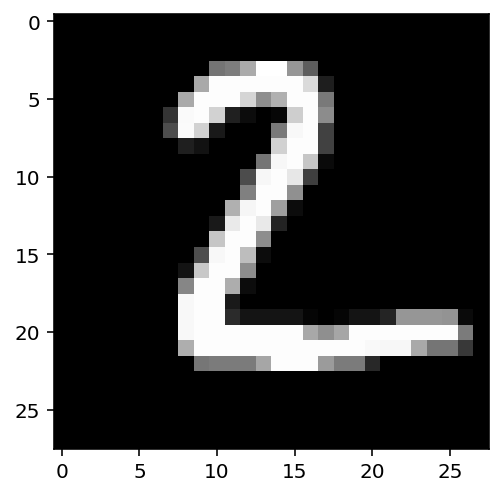

In [4]:
# 이미지가 어떻게 생겼는지 확인
training_set = DataLoader(data_train, batch_size=32)
dataIter = iter(training_set)
dataImage, dataLabel = dataIter.next()
npdataImage = dataImage.numpy()
print(npdataImage.shape)
npdataImage = npdataImage[1]
plt.imshow(np.squeeze(np.transpose(npdataImage, (1,2,0))), cmap='gray')
print(dataLabel[1])

In [25]:
#https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/
#nn.conv2d와 layer.conv2d 차이
#https://excelsior-cjh.tistory.com/180
# conv2d
#https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
# batchNorm2d
#https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
# 

class YeomNN(nn.Module):
    def __init__(self, num_classes=10, size_kernel=3):
        super(YeomNN, self).__init__()
        # 실행 순서 
        # feature layer를 통해서 특징 추출
        # view를 통해서 reshape
        # classifier에 집어넣어 fully connected layer에 넣기
        # 결과 출력
        self.number_class   = num_classes
        self.size_kernel    = size_kernel
        # *********************************************************************
        # feature layer
        # *********************************************************************
        # 1 layer
        # glorot_uniform으로 값 초기화 빠른 초기 학습 효과
        self.conv1 = nn.Conv2d(1,16,kernel_size=size_kernel,padding=int((size_kernel-1)/2))
        # gradient 연산을 잘 하기 위해 Batchnorm 추가 32는 Mnist channel이 32이라 (1,28,28)-> conv(32,28,28?)
        # gradient vanish 제거 LeakyReLU 사용 
        self.layer1 = nn.Sequential(self.conv1, nn.BatchNorm2d(16), nn.LeakyReLU(0.01))
        # 2 layer
        # 오버피팅 제거 (Droupout은 노드를 랜덤으로 p 비율만큼 제거함)
        self.conv2 = nn.Conv2d(16,32,kernel_size=size_kernel, padding=int((size_kernel-1)/2))
        # 28*28 output 인것이 14*14로 바뀌여서 MaxPool을 이용해 2*2 -> 1 로 줄임
        self.layer2 = nn.Sequential(self.conv2, nn.BatchNorm2d(32), nn.LeakyReLU(0.01),nn.MaxPool2d(2))
        # 3 layer
        # 128까지 확대해보자
        self.conv3 = nn.Conv2d(32,64,kernel_size=size_kernel, padding=int((size_kernel-1)/2))
        self.layer3 = nn.Sequential(self.conv3, nn.BatchNorm2d(64), nn.LeakyReLU(0.01),nn.MaxPool2d(2))      
        # 작정하고 깊게 해보자
        self.feature = nn.Sequential(self.layer1,self.layer2,self.layer3)

        # *********************************************************************
        # classifier layer
        # *********************************************************************
        # Maxpooling 할때마다 28*28이 1/2로 감소함 MP 3번했으니 3.5*3.5(3으로 내림) 
        self.fc1 = nn.Linear(in_features=64*7*7,out_features=128,bias=True)
        self.fcLayer1 = nn.Sequential(self.fc1,nn.BatchNorm1d(128),nn.ReLU(True))

        self.fc2 = nn.Linear(in_features=128,out_features=64,bias=True)
        self.fcLayer2 = nn.Sequential(self.fc2,nn.BatchNorm1d(64),nn.ReLU(True))

        self.fc3 = nn.Linear(in_features=64,out_features=num_classes,bias=True)
        self.fcLayer3 = nn.Sequential(self.fc3,nn.BatchNorm1d(num_classes),nn.ReLU(True))

        self.classifier = nn.Sequential(self.fcLayer1,self.fcLayer2,self.fcLayer3,nn.Softmax(dim=1))

        #self._initialize_weight()


    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        out = self.classifier(x)
        return out


## define loss function and optimizer

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = YeomNN().to(device)
#print(model)
learning_rate_value = 0.001
criterion = nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_value, momentum=0.9, weight_decay=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_value)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate_value)
#scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[20], gamma= 1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=0.1, patience=1, mode='min') 

## Training

In [35]:
batch_size = 32
max_epoch = 20
print_interval = 5

training_set = DataLoader(data_train, batch_size=batch_size, shuffle=True)
testing_set = DataLoader(data_test, batch_size=batch_size, shuffle=True)

trainLoss = []
trainAcc = []
testLoss = []
testAcc = []

for epoch in range(max_epoch):
  correct = 0
  total = 0
  batchIdx = 0
  # for training data and gradient descendent
  for trainData in training_set:
    batchIdx += 1
    inputV = trainData[0].to(device)
    labelV = trainData[1].to(device)
    # 역전파 단계를 실행하기 전에 변화도를 0으로 만듭니다.
    optimizer.zero_grad()
    outputV = model(inputV)# forward 실행
    loss = criterion(outputV, labelV)
    loss.backward()# 역전파 실행
    optimizer.step()
    for i in range(len(labelV)):
      # 총 데이터 개수
      total += 1
      # output 중에서 가장 큰 값의 index 값을 꺼내오자
      predic = torch.max(outputV[i], 0)[1]
      # label 이랑 outputV 랑 같은 것이 있으면 (eq 이후 T F 가 나오고 sum 이후 +1 또는 0을 더함)
      correct += predic.eq(labelV[i]).sum()
  trainLoss.append(loss.item())
  acc = 100. * correct.item()/total
  trainAcc.append(acc)
  if epoch % print_interval == 0:
    print('Training ' +str(epoch) + ' : ' + str(acc) + ' : ' + str(loss.item()))
    print('Learning rate {}'.format(scheduler.optimizer.state_dict()['param_groups'][0]['lr']))
  scheduler.step(loss)
  # for test data
  correct = 0
  total = 0
  batchIdx = 0
  for testData in testing_set:
    inputV = testData[0].to(device)
    labelV = testData[1].to(device)
    outputV = model(inputV)
    # test 데이터이기 때문에 loss 값을 이용해 모델을 업데이트 할 필요는 없다.
    loss = criterion(outputV, labelV)
    for i in range(len(labelV)):
      total += 1
      predic = torch.max(outputV[i], 0)[1]
      correct += predic.eq(labelV[i]).sum()
  testLoss.append(loss.item())
  acc = 100. * correct.item()/total
  testAcc.append(acc)
  if epoch % print_interval == 0:
    print('Testing ' +str(epoch) + ' : ' + str(acc) + ' : ' + str(loss.item()))
  

Training 0 : 98.31 : 1.8052012920379639
Learning rate 1.0000000000000004e-08
Testing 0 : 96.16333333333333 : 1.7012877464294434
Training 5 : 97.97 : 1.6903218030929565
Learning rate 1.0000000000000004e-08
Testing 5 : 96.13666666666667 : 1.7379213571548462
Training 10 : 98.3 : 1.6652171611785889
Learning rate 1.0000000000000004e-08
Testing 10 : 96.21833333333333 : 1.6933560371398926
Training 15 : 98.01 : 1.7722710371017456
Learning rate 1.0000000000000004e-08
Testing 15 : 96.075 : 1.6392594575881958


## All test set accuracy

In [47]:
testing_set = DataLoader(data_test,batch_size=256)
# for test data
correct = 0
total = 0
batchIdx = 0
for testData in testing_set:
  inputV = testData[0].to(device)
  labelV = testData[1].to(device)
  outputV = model(inputV)
  # test 데이터이기 때문에 loss 값을 이용해 모델을 업데이트 할 필요는 없다.
  loss = criterion(outputV, labelV)
  for i in range(len(labelV)):
    total += 1
    predic = torch.max(outputV[i], 0)[1]
    correct += predic.eq(labelV[i]).sum()
acc = 100. * correct.item()/total
print('Testing : ' + str(acc) + ' : ' + str(loss.item()))

Testing : 98.43 : 1.6243761777877808


##[output]

## 1. Plot the training and testing losses over epochs

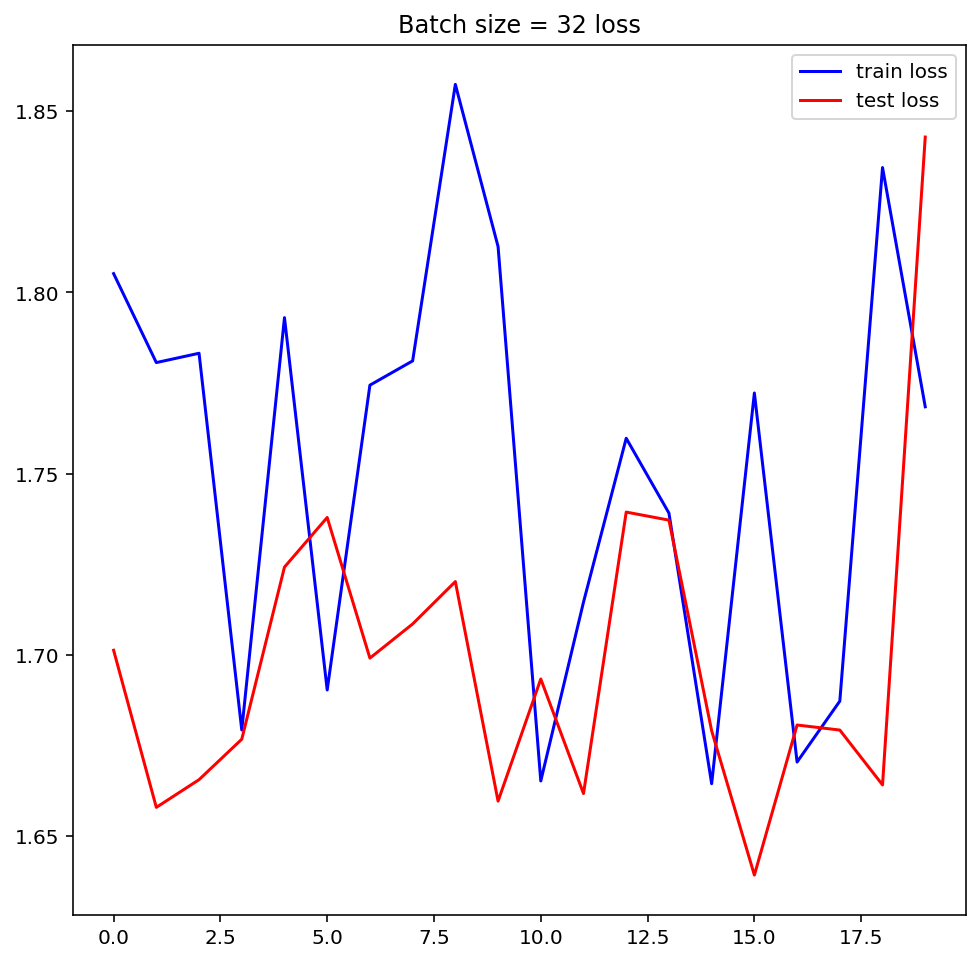

In [48]:
plt.figure(1,figsize=(8,8))
plt.plot(range(len(trainLoss)),trainLoss,c='blue', label='train loss')
plt.plot(range(len(testLoss)),testLoss,c='red', label='test loss')
plt.title('Batch size = '+ str(batch_size) +' loss')
plt.legend()
plt.show()

## 2. Plot the training and testing accuracies over epochs

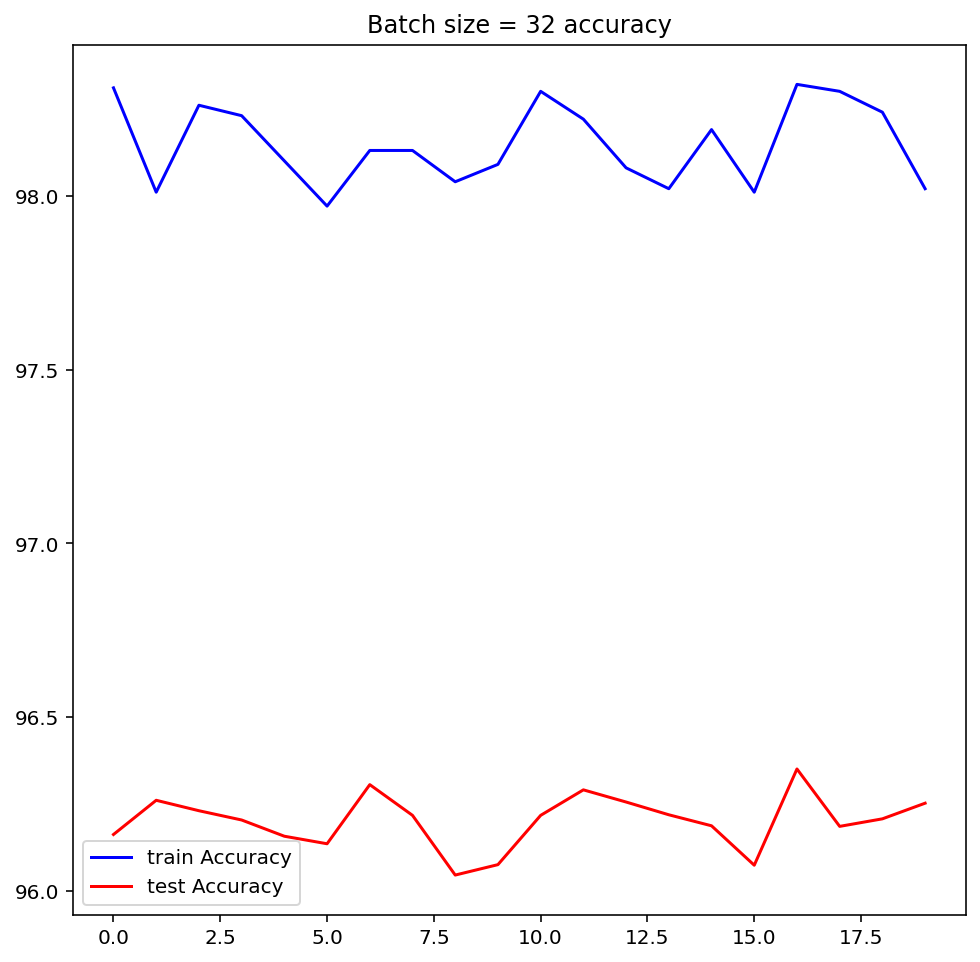

In [49]:
plt.figure(1,figsize=(8,8))
plt.plot(range(len(trainAcc)),trainAcc,c='blue', label='train Accuracy')
plt.plot(range(len(testAcc)),testAcc,c='red', label='test Accuracy')
plt.title('Batch size = '+str(batch_size)+' accuracy')
plt.legend()
plt.show()

## 3. Print the final training and testing losses at convergence
소수점 5째 자리까지 표기하시오

In [50]:
print(trainLoss[-1])
print(testLoss[-1])

1.768454909324646
1.8428813219070435


| loss              |            |
| ----------------- | ---------- |
| training          | 0.12345    | 
| testing           | 0.12345    | 


## 4. Print the final training and testing accuracies at convergence
소수점 5째 자리까지

In [51]:
print(trainAcc[-1])
print(testAcc[-1])

98.02
96.25333333333333


| accuracy          |            |
| ----------------- | ---------- |
| training          | 0.98765    | 
| testing           | 0.97650    | 


## 5. Print the testing accuracies within the last 10 epochs
소수점 5째 자리까지

In [41]:
for i in range(max_epoch-10, max_epoch):
  print("[epoch={}] {}".format(i, testAcc[i]))

[epoch=10] 96.21833333333333
[epoch=11] 96.29166666666667
[epoch=12] 96.25666666666666
[epoch=13] 96.22
[epoch=14] 96.18833333333333
[epoch=15] 96.075
[epoch=16] 96.35166666666667
[epoch=17] 96.18666666666667
[epoch=18] 96.20833333333333
[epoch=19] 96.25333333333333
